In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 3s (3,174 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123069 files and di

In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 32.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt
from PIL import Image
import re
import time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import os
import sys
import urllib.request
import json
import joblib
from google.colab import files

%matplotlib inline

In [4]:
okt = Okt()

In [5]:
plt.rc('font', family = 'NanumBarunGothic')

# **함수**

In [6]:
def okts_return_lists(df, column, keyword):
    str_list = []
    for temp in df[column]:
        str_list.append(temp)

    str = ''.join(str_list)

    okt = Okt()
    nouns = okt.nouns(str)
    pos = okt.pos(str, stem = True)
    morphs = okt.morphs(str)

    n_words = []
    for n in nouns:
        if len(n) > 1:
            n_words.append(n)

    p_words = []
    for p in pos:
        if len(p[0]) > 1 and 'Adjective' == p[1]:
            p_words.append(p[0])
        elif len(p[0]) > 1 and 'Verb' == p[1]:
            p_words.append(p[0])

    m_words = []
    for m in morphs:
        if len(m) > 1:
            m_words.append(m)

    return n_words, p_words, m_words

In [7]:
def get_intersection(dict1, dict2):
  result = {}

  for key1 in list(dict1.keys()):
    for key2 in list(dict2.keys()):
      if key1 == key2:
        if dict1[key1] >= dict2[key2]:
          result[key2] = dict2[key2]
        else:
          result[key1] = dict1[key1]

  return result

In [8]:
def get_difference(list1, list2):
  for text2 in list2:
    if text2 in list1:
      try:
        list1.remove(text2)
      except:
        pass

  return list1

In [20]:
def get_3_intersection(df1, df2, df3, keyword1, keyword2, keyword3, i):
  re2_n_words, re2_p_words, re2_m_words = okts_return_lists(df1, 'description', keyword1)
  re_n_words, re_p_words, re_m_words = okts_return_lists(df2, 'description', keyword2)
  n_words, p_words, m_words = okts_return_lists(df3, 'description', keyword3)

  n_c = get_intersection(Counter(re_n_words), Counter(n_words))
  p_c = get_intersection(Counter(re_p_words), Counter(p_words))
  m_c = get_intersection(Counter(re_m_words), Counter(m_words))

  int_n_c = get_intersection(n_c, Counter(re2_n_words))
  int_p_c = get_intersection(p_c, Counter(re2_p_words))
  int_m_c = get_intersection(m_c, Counter(re2_m_words))

  temp = sorted(int_n_c.items(), key = lambda x: x[1], reverse = True)
  int_n_c = dict(temp[i:])

  temp = sorted(int_p_c.items(), key = lambda x: x[1], reverse = True)
  int_p_c = dict(temp[i:])

  temp = sorted(int_m_c.items(), key = lambda x: x[1], reverse = True)
  int_m_c = dict(temp[i:])

  return int_n_c, int_p_c, int_m_c

In [9]:
# 교집합 구하기
def make_intersection(df1, df2, keyword1, keyword2, i):
  re_n_words, re_p_words, re_m_words = okts_return_lists(df1, 'description', keyword1)
  n_words, p_words, m_words = okts_return_lists(df2, 'description', keyword2)

  int_n_c = get_intersection(Counter(re_n_words), Counter(n_words))
  int_p_c = get_intersection(Counter(re_p_words), Counter(p_words))
  int_m_c = get_intersection(Counter(re_m_words), Counter(m_words))

  temp = sorted(int_n_c.items(), key = lambda x: x[1], reverse = True)
  int_n_c = dict(temp[i:])

  temp = sorted(int_p_c.items(), key = lambda x: x[1], reverse = True)
  int_p_c = dict(temp[i:])

  temp = sorted(int_m_c.items(), key = lambda x: x[1], reverse = True)
  int_m_c = dict(temp[i:])

  return int_n_c, int_p_c, int_m_c

In [10]:
# 차집합 구하기
def make_difference(df1, df2, keyword1, keyword2, i):
  re_n_words, re_p_words, re_m_words = okts_return_lists(df1, 'description', keyword1)
  n_words, p_words, m_words = okts_return_lists(df2, 'description', keyword2)

  dif_n_words = get_difference(re_n_words, n_words)
  dif_p_words = get_difference(re_p_words, p_words)
  dif_m_words = get_difference(re_m_words, m_words)

  dif_n_c = Counter(dif_n_words)
  dif_p_c = Counter(dif_p_words)
  dif_m_c = Counter(dif_m_words)

  temp = sorted(dif_n_c.items(), key = lambda x: x[1], reverse = True)
  dif_n_c = dict(temp[i:])

  temp = sorted(dif_p_c.items(), key = lambda x: x[1], reverse = True)
  dif_p_c = dict(temp[i:])

  temp = sorted(dif_m_c.items(), key = lambda x: x[1], reverse = True)
  dif_m_c = dict(temp[i:])

  return dif_n_c, dif_p_c, dif_m_c

In [11]:
def wordclouds_gen(c):
    wc = WordCloud(font_path='NanumBarunGothic', width=1000, height=1000, scale=5.0, max_font_size=625, background_color = 'white')
    gen = wc.generate_from_frequencies(c)

    return gen

In [12]:
def wordclouds_maker(keyword, c1, c2, c3):
  gen1 = wordclouds_gen(c1)
  gen2 = wordclouds_gen(c2)
  gen3 = wordclouds_gen(c3)
  gen_list = [gen1, gen2, gen3]

  fig, axes = plt.subplots(1, 3, figsize=(15,10))
  for i, gen in enumerate(gen_list):
    axes[i].imshow(gen)
    axes[i].set_title(keyword + '에 대한 워드클라우드')
    axes[i].axis('off')

In [32]:
def wordclouds_one_maker(keyword, c):
  gen = wordclouds_gen(c)
  plt.imshow(gen)
  plt.title(keyword + '에 대한 워드클라우드')
  plt.axis('off')

In [13]:
f_path = 'drive/MyDrive/메타버스아카데미 6월 프로젝트/[차민수] data/'

def save_file_to_csv(df, f_path):
    file_name = input('확장자명을 제외한 파일 이름을 입력하세요: ')
    df.to_csv(os.path.join(f_path, file_name + '.csv'), index = False)
    time.sleep(10)

def save_jpgs(f_path):
  file_name = input('파일 이름을 입력해주세요: ')
  plt.savefig(f_path + file_name + '.jpg')

# **키워드 비교: 우리 아들, 딸 vs ADHD**

In [14]:
# 우리 아들 / 우리 딸과 adhd 검색의 교집합과 차집합 구하기
son = pd.read_csv('/content/drive/MyDrive/메타버스아카데미 6월 프로젝트/[차민수] data/my_son.csv')
daughter = pd.read_csv('/content/drive/MyDrive/메타버스아카데미 6월 프로젝트/[차민수] data/my_daughter.csv')
adhd = pd.read_csv('/content/drive/MyDrive/메타버스아카데미 6월 프로젝트/[차민수] data/adhd.csv')

son = son.dropna()
daughter = daughter.dropna()
adhd = adhd.dropna()

파일 이름을 입력해주세요: son_and_daughter_with_adhd_0


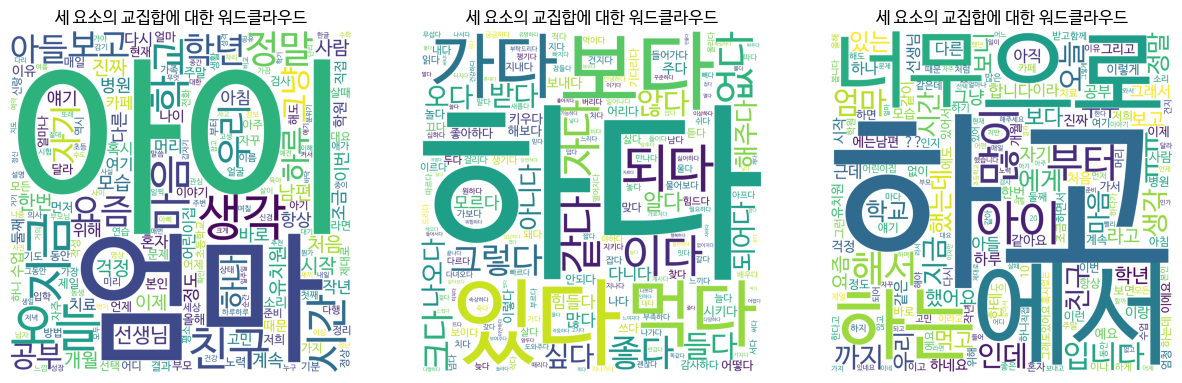

In [21]:
int_n_c, int_p_c, int_m_c = get_3_intersection(son, daughter, adhd, '우리 아들', '우리 딸', 'ADHD', 0)
wordclouds_maker('세 요소의 교집합', int_n_c, int_p_c, int_m_c)
save_jpgs(f_path)

파일 이름을 입력해주세요: son_and_daughter_with_adhd_20


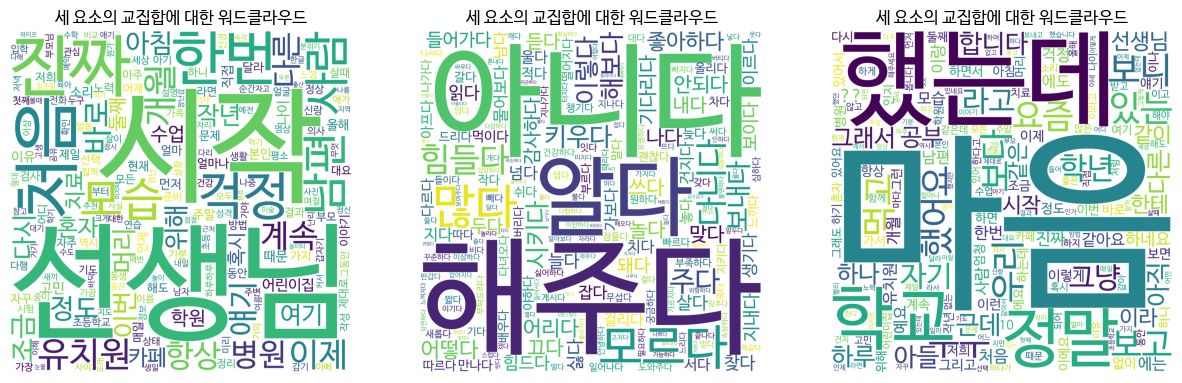

In [22]:
int_n_c, int_p_c, int_m_c = get_3_intersection(son, daughter, adhd, '우리 아들', '우리 딸', 'ADHD', 20)
wordclouds_maker('세 요소의 교집합', int_n_c, int_p_c, int_m_c)
save_jpgs(f_path)

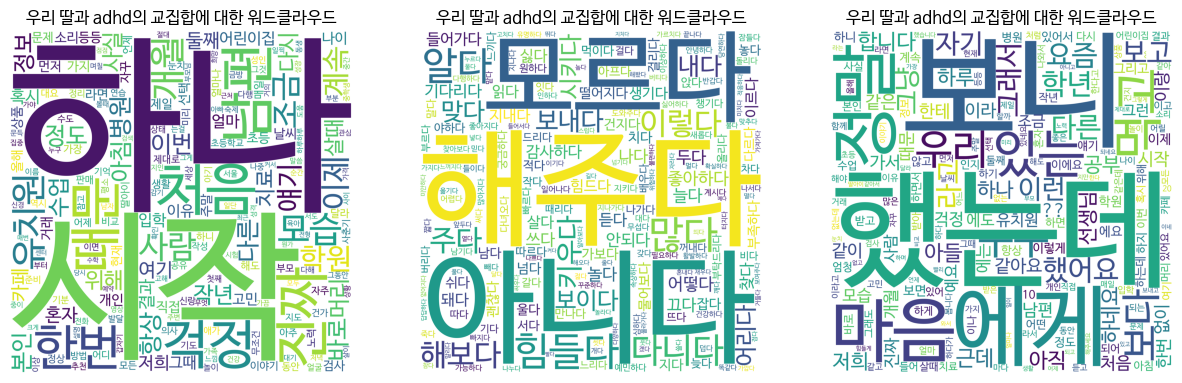

In [ ]:
int_n_c, int_p_c, int_m_c = make_intersection(adhd, daughter, 'ADHD', '우리 딸', 20)
wordclouds_maker('우리 딸과 adhd의 교집합', int_n_c, int_p_c, int_m_c)

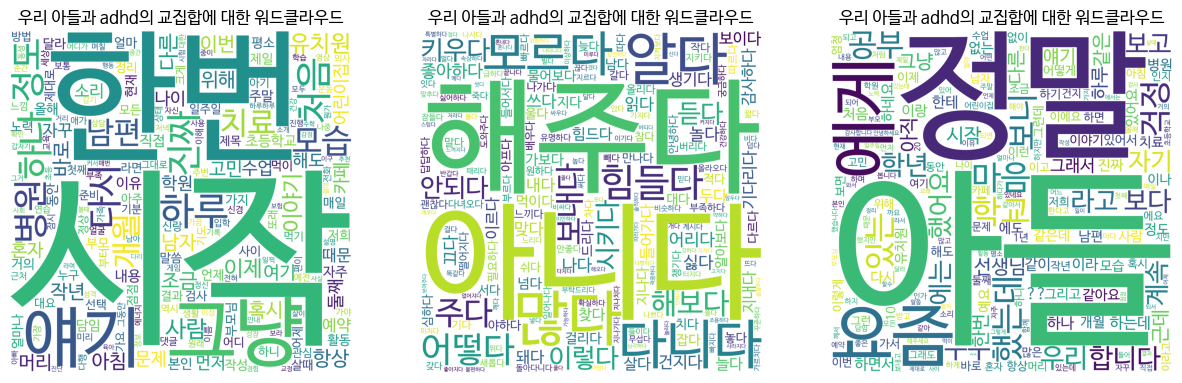

In [ ]:
# 교집합 구하기 : 우리 아들과 adhd의 교집합
int_n_c, int_p_c, int_m_c = make_intersection(adhd, son, 'ADHD', '우리 아들', 20)
wordclouds_maker('우리 아들과 adhd의 교집합', int_n_c, int_p_c, int_m_c)

# **키워드 비교: 우리 아들, 딸 vs 정신과**

In [23]:
psychiatry = pd.read_csv('/content/drive/MyDrive/메타버스아카데미 6월 프로젝트/[차민수] data/psychiatry.csv')
psychiatry = psychiatry.dropna()

파일 이름을 입력해주세요: son_and_daughter_with_ psychiatry_0


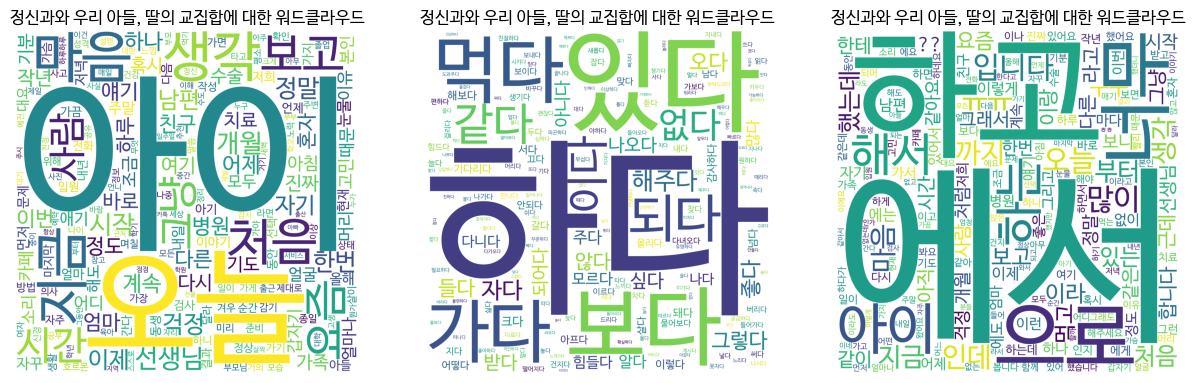

In [24]:
int_n_c, int_p_c, int_m_c = get_3_intersection(son, daughter, psychiatry, '우리 아들', '우리 딸', '정신과', 0)
wordclouds_maker('정신과와 우리 아들, 딸의 교집합', int_n_c, int_p_c, int_m_c)
save_jpgs(f_path)

In [25]:
print('명사 공통: ', int_n_c)  # 혹시 39번째, 13회 갑자기 53번째, 11회
print('동사 형용사 공통: ', int_p_c) #
print('형태소 공통: ', int_m_c)

명사 공통:  {'아이': 103, '오늘': 60, '마음': 51, '생각': 50, '지금': 50, '처음': 42, '보고': 37, '요즘': 33, '그냥': 28, '시간': 27, '사람': 25, '선생님': 25, '시작': 24, '개월': 24, '정말': 23, '한번': 22, '걱정': 22, '남편': 21, '이제': 21, '자기': 20, '하나': 18, '어제': 18, '계속': 18, '엄마': 17, '친구': 17, '병원': 17, '이번': 17, '다른': 17, '얘기': 17, '정도': 17, '하루': 16, '혼자': 16, '바로': 16, '여기': 15, '다시': 15, '작년': 15, '진짜': 14, '치료': 14, '혹시': 13, '가족': 13, '수술': 13, '기도': 13, '아침': 12, '머리': 12, '고민': 12, '조금': 12, '기분': 12, '카페': 12, '어디': 11, '때문': 11, '소리': 11, '이유': 11, '갑자기': 11, '애기': 10, '얼굴': 10, '얼마나': 10, '모두': 10, '본인': 10, '해도': 9, '눈물': 9, '주말': 9, '자꾸': 9, '저녁': 9, '올해': 9, '내일': 9, '대요': 9, '먼저': 9, '이야기': 9, '저희': 9, '얼마': 9, '가지': 9, '현재': 9, '문제': 9, '언제': 8, '아들': 8, '마지막': 8, '아기': 8, '검사': 8, '결과': 8, '가끔': 8, '내년': 8, '동생': 8, '동안': 8, '다음': 8, '간다': 8, '전화': 8, '선택': 8, '입원': 8, '가슴': 8, '순간': 7, '자주': 7, '가기': 7, '달라': 7, '정상': 7, '방법': 7, '가면': 7, '작성': 7, '하니': 7, '준비': 6, '살이': 6, '겨우': 6, '며칠': 6, '미리': 6, 

파일 이름을 입력해주세요: son_and_daughter_with_ psychiatry_20


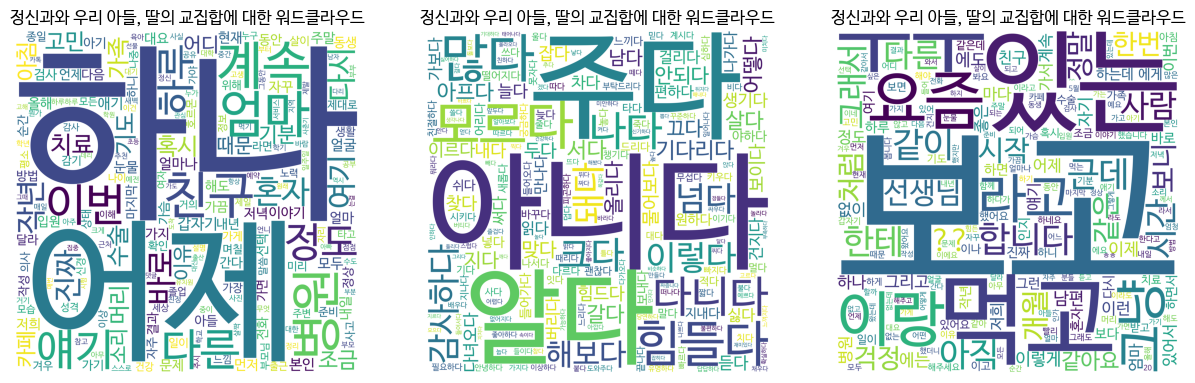

In [30]:
int_n_c, int_p_c, int_m_c = get_3_intersection(son, daughter, psychiatry, '우리 아들', '우리 딸', '정신과', 20)
wordclouds_maker('정신과와 우리 아들, 딸의 교집합', int_n_c, int_p_c, int_m_c)
save_jpgs(f_path)

파일 이름을 입력해주세요: son_and_daughter_with_ psychiatry_20_nouns


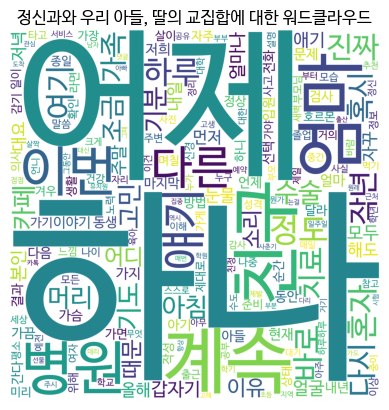

In [33]:
wordclouds_one_maker('정신과와 우리 아들, 딸의 교집합', int_n_c)
save_jpgs(f_path)

키워드 : 혹시, 갑자기

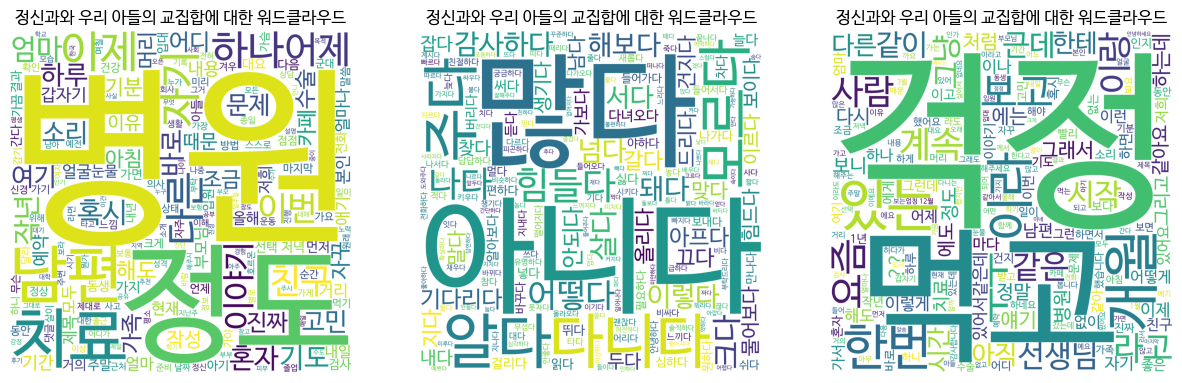

In [ ]:
int_n_c, int_p_c, int_m_c = make_intersection(psychiatry, son, '정신과', '우리 아들', 20)
wordclouds_maker('정신과와 우리 아들의 교집합', int_n_c, int_p_c, int_m_c)

키워드 : 혹시, 치료, 갑자기. 이야기

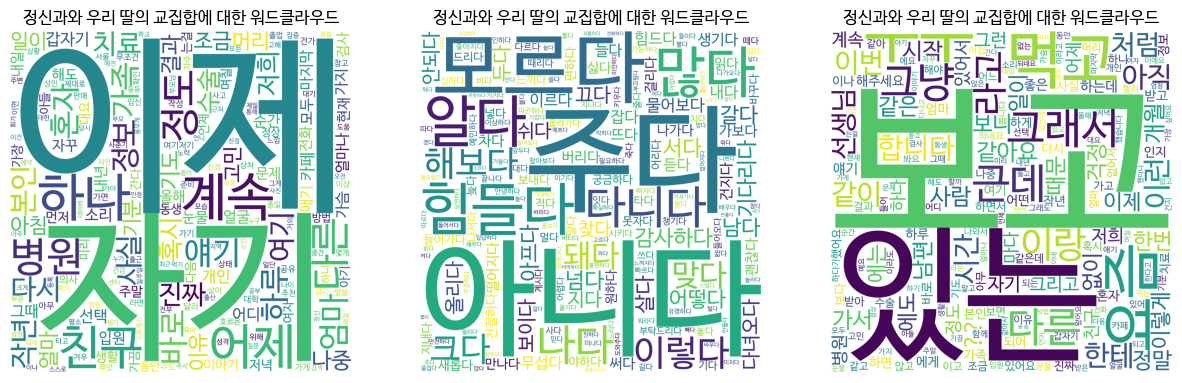

In [ ]:
int_n_c, int_p_c, int_m_c = make_intersection(psychiatry, daughter, '정신과', '우리 딸', 20)
wordclouds_maker('정신과와 우리 딸의 교집합', int_n_c, int_p_c, int_m_c)

# **키워드 비교: 정신과 vs adhd**

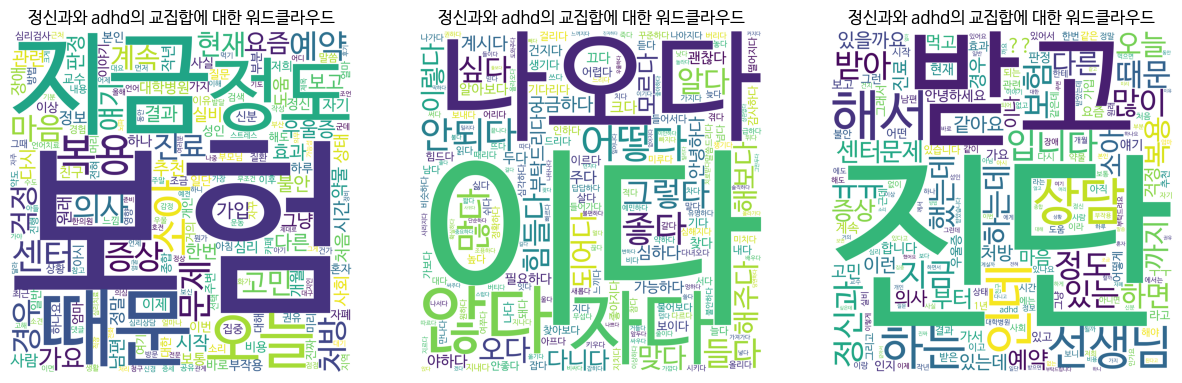

In [ ]:
int_n_c, int_p_c, int_m_c = make_intersection(psychiatry, adhd, '정신과', 'adhd', 10)
wordclouds_maker('정신과와 adhd의 교집합', int_n_c, int_p_c, int_m_c)

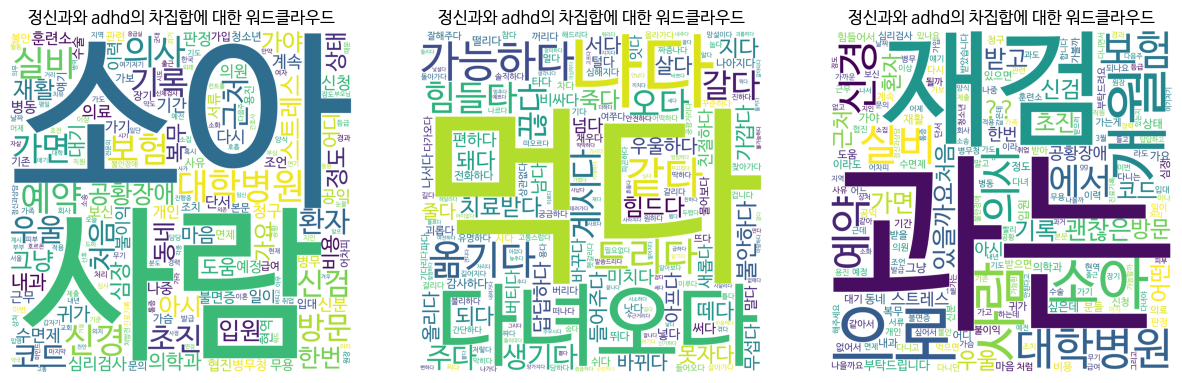

In [ ]:
dif_n_c, dif_p_c, dif_m_c = make_difference(psychiatry, adhd, '정신과', 'adhd', 10)
wordclouds_maker('정신과와 adhd의 차집합', dif_n_c, dif_p_c, dif_m_c)

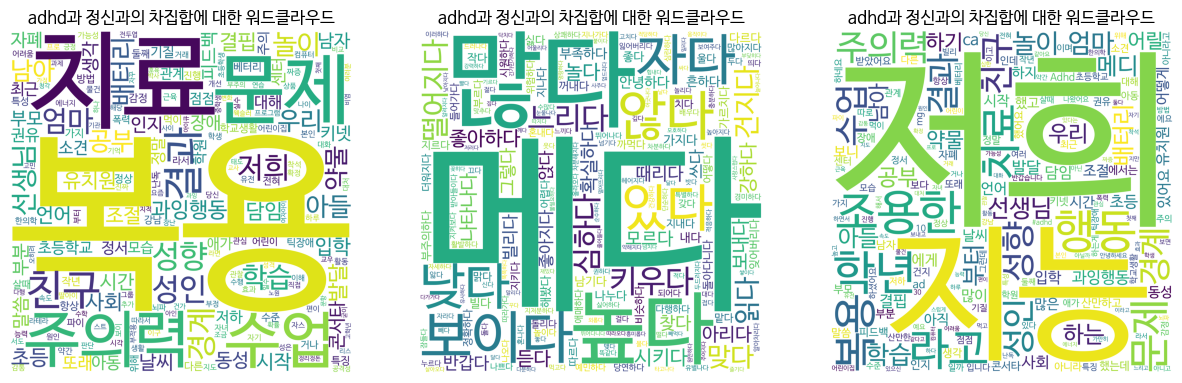

In [ ]:
dif_n_c, dif_p_c, dif_m_c = make_difference(adhd, psychiatry, 'adhd', '정신과', 10)
wordclouds_maker('adhd과 정신과의 차집합', dif_n_c, dif_p_c, dif_m_c)

# **키워드 비교: 우리 아들, 딸 vs 아이 혹시**

In [ ]:
kids_if = pd.read_csv('/content/drive/MyDrive/메타버스아카데미 6월 프로젝트/[차민수] data/kids_if.csv')
kids_if = kids_if.dropna()

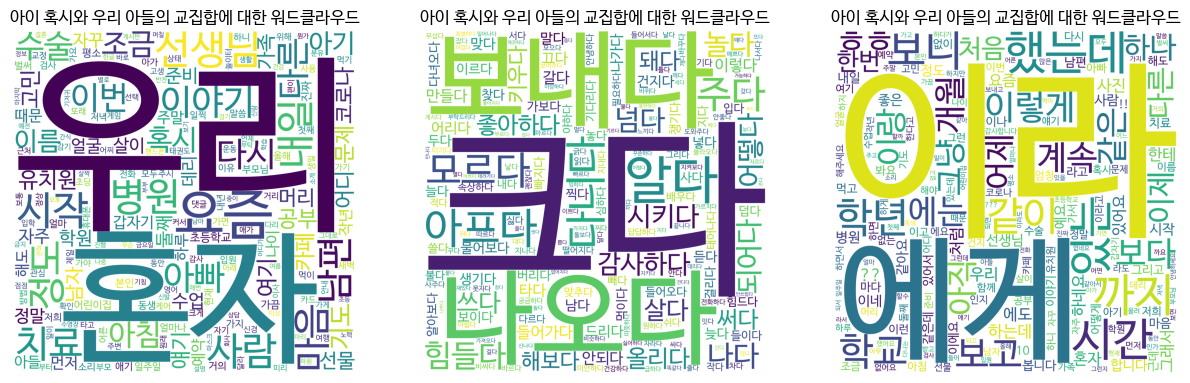

In [ ]:
int_n_c, int_p_c, int_m_c = make_intersection(kids_if, son, '아이 혹시', '우리 아들', 20)
wordclouds_maker('아이 혹시와 우리 아들의 교집합', int_n_c, int_p_c, int_m_c)

**주목할만한 키워드: 고민, 검사**

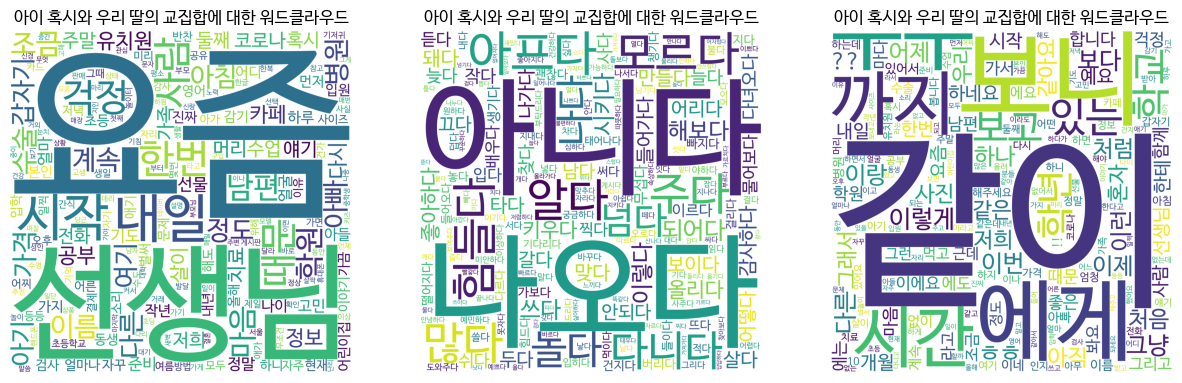

In [ ]:
int_n_c, int_p_c, int_m_c = make_intersection(kids_if, daughter, '아이 혹시', '우리 딸', 20)
wordclouds_maker('아이 혹시와 우리 딸의 교집합', int_n_c, int_p_c, int_m_c)

**주목할만한 키워드: 갑자기, 얘기**

# **키워드 비교: 우리 아들, 딸 vs 아이 갑자기**

In [ ]:
kids_suddenly = pd.read_csv('/content/drive/MyDrive/메타버스아카데미 6월 프로젝트/[차민수] data/kids_suddenly.csv')
kids_suddenly = kids_suddenly.dropna()

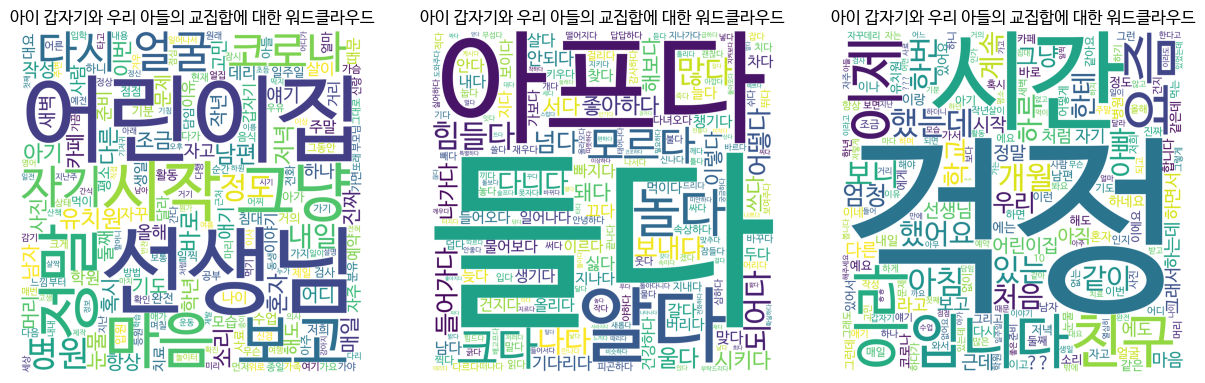

In [ ]:
int_n_c, int_p_c, int_m_c = make_intersection(kids_suddenly, son, '아이 갑자기', '우리 아들', 20)
wordclouds_maker('아이 갑자기와 우리 아들의 교집합', int_n_c, int_p_c, int_m_c)

**주목할만한 키워드: 눈물**

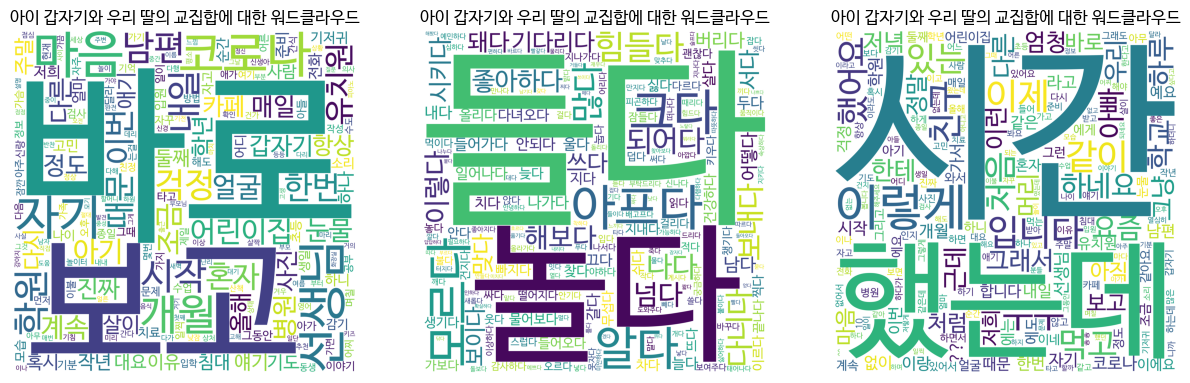

In [ ]:
int_n_c, int_p_c, int_m_c = make_intersection(kids_suddenly, daughter, '아이 갑자기', '우리 딸', 20)
wordclouds_maker('아이 갑자기와 우리 딸의 교집합', int_n_c, int_p_c, int_m_c)

**주목할만한 키워드: 눈물, 혹시**